<a href="https://colab.research.google.com/github/ja20835/team25.Titanic/blob/main/Team25_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialise imports and files

In [1]:
# Data Analysis
import pandas as pd
import numpy as np
from google.colab import output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('precision', 3)
pd.set_option('mode.chained_assignment', None)

In [2]:
# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
# PreProcessing & ML Models
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [4]:
# Get DataFiles from GitHub
! git clone https://github.com/ja20835/team25.Titanic.git

# Function to combine DataSets
def combineDataSet(train_data, test_data):
  return pd.concat([train_data, test_data], sort=False).reset_index(drop=True)

# Function to split combined DataSet
def splitDataSet(combined_data):
  return combined_data.loc[:890], combined_data.loc[891:].drop(['Survived'], axis=1)

# Create DataSets for train/test
train = pd.read_csv('team25.Titanic/train.csv')
test = pd.read_csv('team25.Titanic/test.csv')
combined = combineDataSet(train, test)
dfs = [train, test]

# Function to show correlation from 1 feature to others
corr = combined.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Corr'}, inplace=True)

# Remove redundent output from this section
output.clear()

# Visualise Raw Data

In [5]:
# Show samples of train, test and combined DataSets

print('Shape of train: ', train.shape)
print(train.sample(3), '\n')

print('Shape of test: ', test.shape)
print(test.sample(3), '\n')

print('Shape of combined: ', combined.shape)
print(combined.sample(3))

Shape of train:  (891, 12)
     PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch  Ticket    Fare Cabin Embarked
32            33         1       3                           Glynn, Miss. Mary Agatha  female   NaN      0      0  335677   7.750   NaN        Q
610          611         0       3  Andersson, Mrs. Anders Johan (Alfrida Konstant...  female  39.0      1      5  347082  31.275   NaN        S
575          576         0       3                               Patchett, Mr. George    male  19.0      0      0  358585  14.500   NaN        S 

Shape of test:  (418, 11)
     PassengerId  Pclass                                               Name     Sex   Age  SibSp  Parch    Ticket     Fare Cabin Embarked
414         1306       1                       Oliva y Ocana, Dona. Fermina  female  39.0      0      0  PC 17758  108.900  C105        C
157         1049       3                           Lundin, Miss. Olga Elida  female  23.0

# Age

In [6]:
# Show number of nulls in Age column
# Show correlation of Age to other existing columns

print('Amount of Nulls:', combined.Age.isnull().sum(), '\n')
corr[corr['Feature 1'] == 'Age']

Amount of Nulls: 263 



,Feature 1,Feature 2,Corr
5,Age,Age,1.000
10,Age,Pclass,0.408
17,Age,SibSp,0.244
21,Age,Fare,0.179
25,Age,Parch,0.151
29,Age,Survived,0.077
42,Age,PassengerId,0.029


In [7]:
# Calculate and insert mean Age for missing rows, using Sex and Pclass for more accurate ages

meanAge = combined.groupby(['Sex', 'Pclass']).mean()['Age']

for Pclass in range(1, 4):
  for Sex in ['female', 'male']:
    print('Mean age of Pclass {} {}s: {}' .format(Pclass, Sex, meanAge[Sex, Pclass]))
    
combined['Age'] = combined.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.mean()))

Mean age of Pclass 1 females: 37.037593984962406
Mean age of Pclass 1 males: 41.02927152317881
Mean age of Pclass 2 females: 27.499223300970876
Mean age of Pclass 2 males: 30.815379746835443
Mean age of Pclass 3 females: 22.185328947368422
Mean age of Pclass 3 males: 25.962263610315187


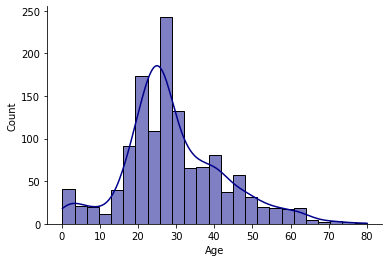

In [8]:
# HistPlot for Age of passengers

sns.histplot(combined['Age'], kde = True, bins = 25, color = 'darkblue')
sns.despine()
combined['qAge'] = pd.qcut(combined['Age'], 12)

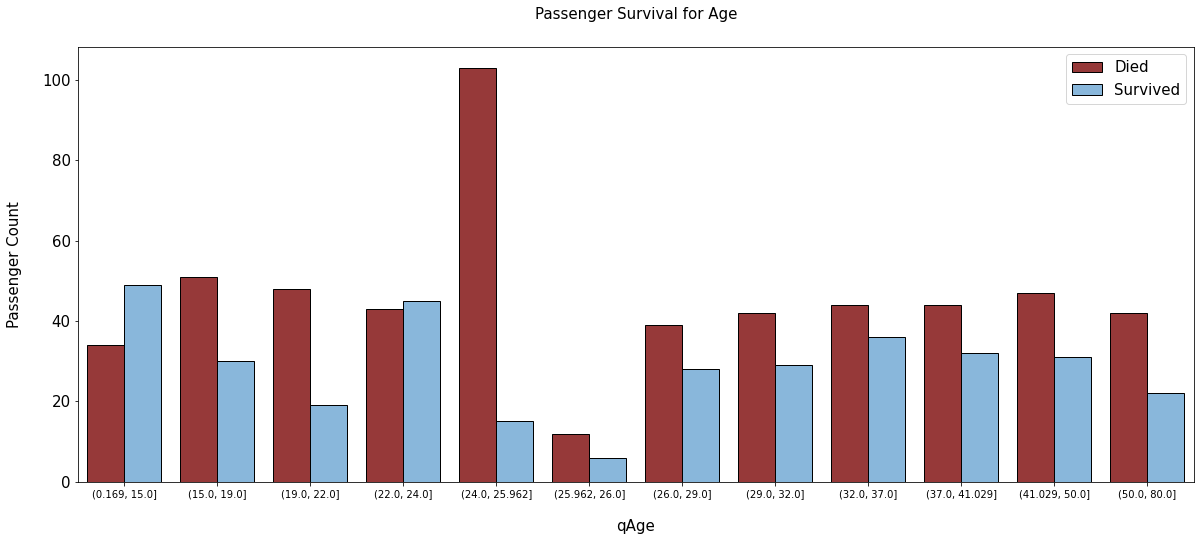

In [9]:
# CountPlot for Age, split by surival

plt.figure(figsize=(20, 8))
sns.countplot(x='qAge', hue='Survived', data=combined, 
              edgecolor='black', palette=['#A52A2A', '#7CB9E8']) 

plt.xlabel('qAge', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Died', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Passenger Survival for {}'.format('Age'), size=15, y=1.05)

plt.show()

# Cabin

In [10]:
# Show number of nulls in Cabin column

print('Amount of Nulls:', combined.Cabin.isnull().sum())

Amount of Nulls: 1014


In [11]:
# Create Deck column from existing Cabin Values
# If Cabin row is null, insert value U for Unknown

combined['Deck'] = combined['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')

combined.drop(['Cabin'], inplace=True, axis=1)

In [12]:
# Group Deck values

combined['Deck'] = combined['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
combined['Deck'] = combined['Deck'].replace(['D', 'E'], 'DE')
combined['Deck'] = combined['Deck'].replace(['F', 'G'], 'FG')

In [13]:
# Add Deck value for passengers with Pclass1 and current U
# We do this as we know all Pclass1 passengers were in the ABC Deck group

Pclass = combined['Pclass']
Deck = combined['Deck']
for x in range(len(Pclass)):
  if Pclass[x] == 1 and Deck[x] == 'U':
    Deck[x] = 'ABC'

In [14]:
combinedSurvival = combined.groupby(['Deck', 'Survived']).count().drop(columns=[
                                      'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                      'Embarked', 'Pclass', 'PassengerId', 'Ticket'
                                      ]).rename(columns={'Name':'Count'}).transpose()

In [15]:
def survivalDistribution(combined):
    # Creating a dictionary for every survival count in every deck
    survivalCount = {'ABC':{}, 'DE':{}, 'FG':{}, 'U':{}}
    decks = combined.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            survivalCount[deck][survive] = combined[deck][survive][0]
            
    survival = pd.DataFrame(survivalCount)
    survivalPercentages = {}

    for col in survival.columns:
        survivalPercentages[col] = [(count / survival[col].sum()) * 100 for count in survival[col]]
        
    return survivalCount, survivalPercentages

In [16]:
def survivalPercent(percentages):    
    survivalPercentages = pd.DataFrame(percentages).transpose()
    decks = ('ABC', 'DE', 'FG', 'U')
    barCount = np.arange(len(decks))  
    barSize = 0.5    

    died = survivalPercentages[0]
    survived = survivalPercentages[1]
    
    plt.figure(figsize=(7, 5))
    plt.bar(barCount, died, color='#A52A2A', edgecolor='black', width=barSize, label="Died")
    plt.bar(barCount, survived, bottom=died, color='#7CB9E8', edgecolor='black', width=barSize, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Percentage', size=15, labelpad=20)
    plt.xticks(barCount, decks)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage for Decks', size=18, y=1.05)
    
    plt.show()

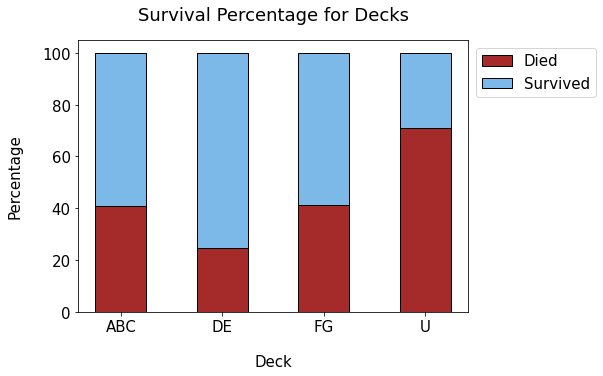

In [17]:
# BarPlot to compare survival percent for Deck groups

combinedSurvivalCount, combinedSurvivalPercent = survivalDistribution(combinedSurvival)
survivalPercent(combinedSurvivalPercent)

# Embarked

In [18]:
# Show number of nulls in Embarked column

print('Amount of Nulls:', combined.Embarked.isnull().sum(), '\n')
combined[combined['Embarked'].isnull()]

Amount of Nulls: 2 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,qAge,Deck
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,"(37.0, 41.029]",ABC
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,"(50.0, 80.0]",ABC


In [19]:
# https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html
# states that both these passengers boarded from Southampton

combined['Embarked'] = combined['Embarked'].fillna('S')

# Fare

In [20]:
# Show number of nulls in Fare column

print('Amount of Nulls:', combined.Fare.isnull().sum(), '\n')
combined[combined['Fare'].isnull()]

Amount of Nulls: 1 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,qAge,Deck
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,"(50.0, 80.0]",U


In [21]:
# Insert similar value for missing Fare row

combined['Fare'] = combined['Fare'].fillna(9.33)
combined['qFare'] = pd.qcut(combined['Fare'], 12)

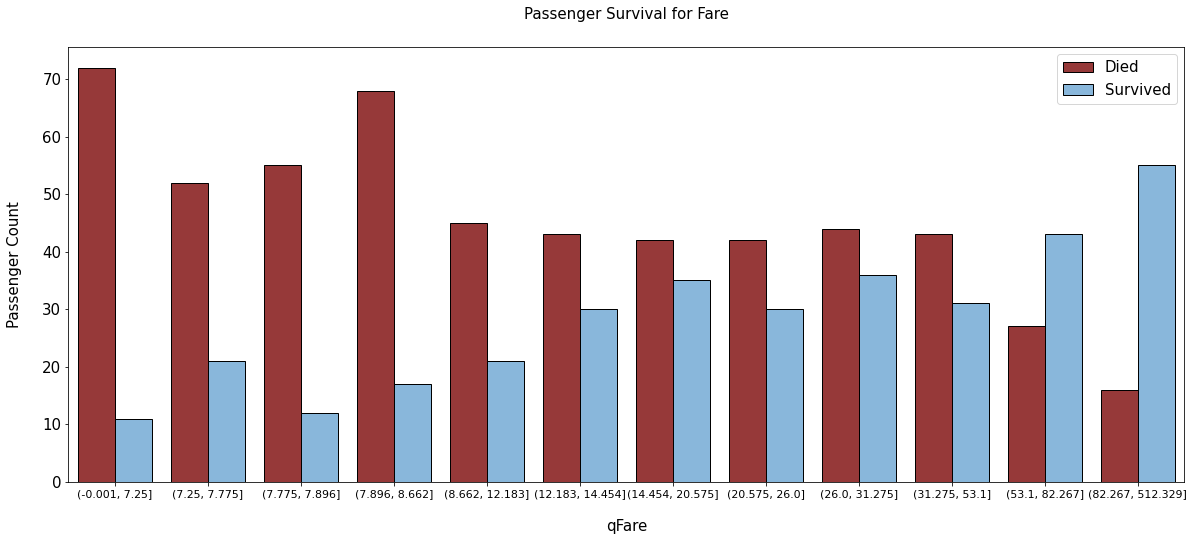

In [22]:
plt.figure(figsize=(20, 8))

sns.countplot(x='qFare', hue='Survived', data=combined, 
              edgecolor='black', palette=['#A52A2A', '#7CB9E8'])

plt.xlabel('qFare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Died', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Passenger Survival for {}'.format('Fare'), size=15, y=1.05)

plt.show()

# GroupSize

In [23]:
# Combine existing SibSp and Parch columns to create new GroupCount column

combined['GroupCount'] = combined['SibSp'] + combined['Parch'] + 1

In [24]:
# Create new columns dependant on GroupCount size

combined['Alone'] = combined['GroupCount'].map(lambda s: 1 if s == 1 else 0)
combined['SmallGroup'] = combined['GroupCount'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined['MedGroup'] = combined['GroupCount'].map(lambda s: 1 if 5 <= s <= 6 else 0)
combined['LargeGroup'] = combined['GroupCount'].map(lambda s: 1 if s >= 7 else 0)

In [25]:
groupMap = {1: 'Alone',
            2: 'SmallGroup', 3: 'SmallGroup', 4: 'SmallGroup', 
            5: 'MedGroup', 6: 'MedGroup',
            7: 'LargeGroup', 8: 'LargeGroup', 11: 'LargeGroup'}
combined['GroupSize'] = combined['GroupCount'].map(groupMap)

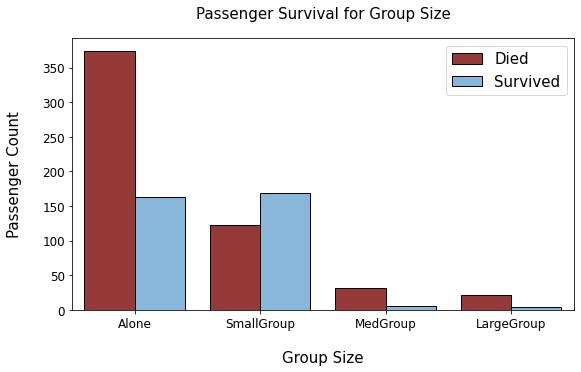

In [26]:
plt.figure(figsize=(9, 5))

sns.countplot(x='GroupSize', hue='Survived', data=combined,  
              order=['Alone', 'SmallGroup', 'MedGroup', 'LargeGroup'], 
              edgecolor='black', palette=['#A52A2A', '#7CB9E8'])

plt.xlabel('Group Size', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.legend(['Died', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Passenger Survival for {}'.format('Group Size'), size=15, y=1.05)

plt.show()

# Name

In [27]:
# Create Title column from existing Name column, using str.split to ignore anything other than the passengers Title

combined['Title'] = combined['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [28]:
# Combine similar titles

combined['Title'] = combined['Title'].replace(['Miss', 'Mlle', 'Ms', 'Mme', 'Dona'], 'Miss')
combined['Title'] = combined['Title'].replace(['Mrs', 'the Countess', 'Lady'], 'Mrs')
combined['Title'] = combined['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Sir', 'Capt', 'Don'], 'Military')

In [29]:
# Search Title column for 'Mrs' values, create new isMarried Column from this

combined['isMarried'] = 0
combined['isMarried'].loc[combined['Title'] == 'Mrs'] = 1

combined.drop(['Name'], inplace=True, axis=1)

# Model Prep

In [30]:
# Create dummies for columns that do not contain numerical data to allow the model to read this data

sex = pd.get_dummies(combined['Sex'], sparse=False)
embarked = pd.get_dummies(combined['Embarked'], sparse=False)
deck = pd.get_dummies(combined['Deck'], sparse=False)
title = pd.get_dummies(combined['Title'], sparse=False)

In [31]:
# Drop pre-dummied columns and other unused columns

combined.drop(['Sex', 'Ticket', 'Embarked', 'Deck', 'GroupSize', 'Title', 'qAge', 'qFare'], 
              axis=1, inplace=True)

In [32]:
# Re-build train and test DataSets from Combined
# Set train Survived column as int64 to remove decimals in the column that will be read incorrectly in Kaggle submission

combined = pd.concat([combined, sex, embarked, deck, title], axis=1)
train, test = splitDataSet(combined)

train.Survived = train.Survived.astype('int64')

In [33]:
# Create training and testing sets for model

X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']
X_test = test

# Hyperparameter Tuning

In [34]:
# # Hyperperameter Tuning for RandomForestClassifier
# # This runs different parameters for the classifier to choose which values fit the best for our training data
# # Commented out to decrease time for prediction after first pass, uncomment if you want to trial it yourself, but expect a 30minute + run time.

# logModel = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

# param_grid = {"criterion" : ["gini", "entropy"], "n_estimators" : [250, 500, 750, 1000, 1250], "max_depth" : [2, 4, 6, 8],
#               "min_samples_leaf" : [2, 4, 6, 8], "min_samples_split" : [1, 3, 4, 5]}
# gs = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)

# best_gs = gs.fit (X_train, y_train)

In [35]:
# # Hyperperameter Tuning for DecisionTreeClassifier
# # This runs different parameters for the classifier to choose which values fit the best for our training data
# # Commented out to decrease time for prediction after first pass, uncomment if you want to trial it yourself, but expect a 30minute + run time.

# logModel = DecisionTreeClassifier(max_features='auto', random_state=1)

# param_grid = {"criterion" : ["gini", "entropy"], "max_depth" : [1, 2, 3, 4, 5, 6, 7, 8],
#               "min_samples_leaf" : [1, 2, 3, 4, 5, 6, 7, 8], "min_samples_split" : [1, 2, 3, 4, 5, 6, 7, 8], 
#               "max_leaf_nodes" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 60, 75, 80, 85, 90, 95, 100]}
# gs = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)

# best_gs = gs.fit (X_train, y_train)

In [36]:
# best_gs.best_estimator_

# Prediction Models

In [37]:
lRegression = LogisticRegression(solver = 'lbfgs', penalty = 'l2', max_iter = 400, C = 0.616, tol = 2)
lRegression.fit(X_train, y_train)
lRegressionY_Predict = lRegression.predict(X_test)
lRegressionAcc = lRegression.score(X_train, y_train)
print('Accuracy with the Logistic Regression model is: ', round(lRegressionAcc, 2))

Accuracy with the Logistic Regression model is:  0.84


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
dTreeR = DecisionTreeRegressor()
dTreeR.fit(X_train, y_train)
dTreeRY_Predict = dTreeR.predict(X_test)
dTreeRAcc = dTreeR.score(X_train, y_train)
print('Accuracy with the Decision Tree Regressor model is: ', round(dTreeRAcc, 2))

Accuracy with the Decision Tree Regressor model is:  1.0


In [39]:
kNN = KNeighborsClassifier(n_neighbors = 3)
kNN.fit(X_train, y_train)
kNNY_Predict = kNN.predict(X_test)
kNNAcc = kNN.score(X_train, y_train)
print('Accuracy with the k-Nearest Neighbors model is: ', round(kNNAcc, 2))

Accuracy with the k-Nearest Neighbors model is:  0.81


In [40]:
rForest = RandomForestClassifier(criterion = 'gini', n_estimators=500, max_depth=6, min_samples_leaf=2, min_samples_split=5)
rForest.fit(X_train, y_train)
rForestY_Predict = rForest.predict(X_test)
rForestAcc = rForest.score(X_train, y_train)
print('Accuracy with the Random Forest model is: ', round(rForestAcc, 2))

Accuracy with the Random Forest model is:  0.86


In [41]:
dTree = DecisionTreeClassifier(criterion='entropy', max_depth = 8, min_samples_split = 8, min_samples_leaf = 3, max_leaf_nodes=25)
dTree.fit(X_train, y_train)
dTreeY_Predict = dTree.predict(X_test)
dTreeAcc = dTree.score(X_train, y_train)
print('Accuracy with the Decision Tree model is: ', round(dTreeAcc, 2))

Accuracy with the Decision Tree model is:  0.86


In [42]:
mlModels = pd.DataFrame({
    'Model': ['Logistic Regression','Decision Tree Regressor','k-Nearest Neighbor','Random Forest','Decision Tree'],
    'Accuracy Score': [lRegressionAcc, dTreeRAcc, kNNAcc, rForestAcc, dTreeAcc], 
    'Percent (%)': [lRegressionAcc * 100, dTreeRAcc * 100, kNNAcc * 100, rForestAcc * 100, dTreeAcc * 100]})
mlModels.sort_values(by = 'Accuracy Score', ascending = False)

,Model,Accuracy Score,Percent (%)
1,Decision Tree Regressor,1.000,100.000
3,Random Forest,0.856,85.634
4,Decision Tree,0.856,85.634
0,Logistic Regression,0.835,83.502
2,k-Nearest Neighbor,0.807,80.696


# Prediction Submission

In [43]:
!rm team25.Titanic/gender_submission.csv
gender_submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':rForestY_Predict})
gender_submission.to_csv('team25.Titanic/gender_submission.csv', index = False)